In [97]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import yt
import cmasher as cmr
import visu_ramses
import matplotlib as mpl
from scipy.interpolate import griddata

In [98]:
# plot params
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [99]:
# define path to data
PATH_prefix = "/scratch/gpfs/ms0821/monte_carlo_CR_2023/public_ramses/ramses/tests/"
PATH_suffix = "mhd/orszag-tang/"
PATH = PATH_prefix + PATH_suffix

In [100]:
# Load RAMSES output
data = visu_ramses.load_snapshot(2)
x = data["data"]["x"]
y = data["data"]["y"]
dx = data["data"]["dx"]
rho = data["data"]["density"]

xp = data["particle"]["position_x"]
yp = data["particle"]["position_y"]
mp = data["particle"]["mass"]

Processing 1 files in output_00002
Total number of cells loaded: 99994
Total particles loaded: 220984


In [101]:
# Check that the tracer total mass agrees with the gas mass within
# 1/sqrt(Ntracer) (~1 sigma for a Poisson distribution)
Mgas = (data["data"]["density"] * data["data"]["dx"]**2).sum()
Mtracer = data["particle"]["mass"].sum()
Ntracer = data["particle"]["mass"].size
rtol = 1/np.sqrt(Ntracer)
np.testing.assert_allclose(Mgas, Mtracer, rtol=rtol)

In [107]:
# Normalize the tracer mass so that their sum equals the box mass
mp = mp * (rho * dx**2).sum() / mp.sum()

xmin = np.amin(x - 0.5 * dx)
xmax = np.amax(x + 0.5 * dx)
ymin = np.amin(y - 0.5 * dx)
ymax = np.amax(y + 0.5 * dx)

nx = 32
dpx = (xmax - xmin) / float(nx)
dpy = (ymax - ymin) / float(nx)
xpx = np.linspace(xmin + 0.5 * dpx, xmax - 0.5 * dpx, nx)
ypx = np.linspace(ymin + 0.5 * dpy, ymax - 0.5 * dpy, nx)
grid_x, grid_y = np.meshgrid(xpx, ypx)
points = np.transpose([x, y])
z1_tracer = griddata(points, rho, (grid_x, grid_y), method="nearest")
z2_tracer = griddata(points, b2, (grid_x, grid_y), method="nearest")
z3_tracer = griddata(points, p, (grid_x, grid_y), method="nearest")
z4_tracer = griddata(points, u2, (grid_x, grid_y), method="nearest")

xbins = np.linspace(xmin, xmax, nx + 1)
ybins = np.linspace(ymin, ymax, nx + 1)
xpoints = np.transpose([xp, yp])
z2, _1, _2 = np.histogram2d(xp, yp, bins=(xbins, ybins), weights=mp)
z2 *= z1_tracer.sum() / z2.sum()
Npart, _1, _2 = np.histogram2d(xp, yp, bins=(xbins, ybins))

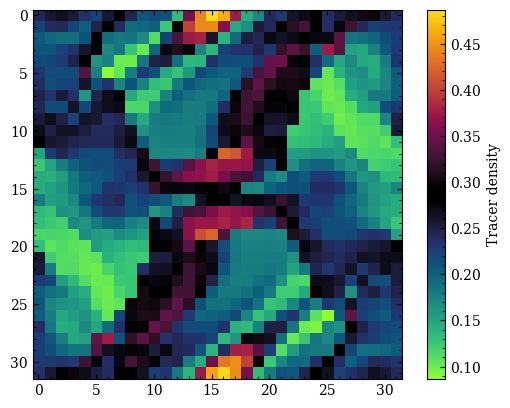

In [108]:
plt.imshow(z1_tracer, cmap='cmr.wildfire')
plt.colorbar(label="Tracer density")

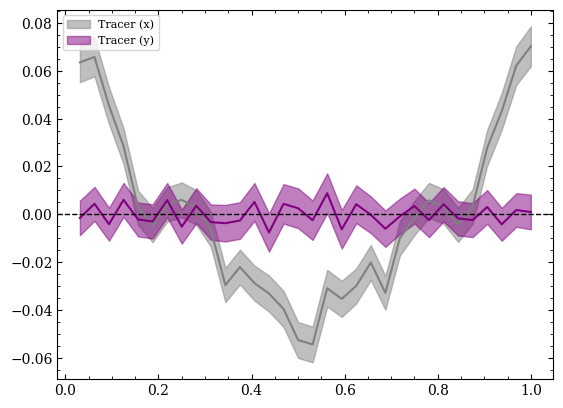

In [109]:
ymean_ref = z1_tracer.mean(axis=0)
ymean = z2.mean(axis=0)
yerr = (z2/np.sqrt(Npart)).mean(axis=0)
plt.plot(xbins[1:], ymean-ymean_ref, c="gray")
plt.fill_between(xbins[1:], ymean-ymean_ref-yerr/2, ymean-ymean_ref+yerr/2, label="Tracer (x)", color="gray", alpha=0.5)

ymean = z2.mean(axis=1)
yerr = (z2/np.sqrt(Npart)).mean(axis=1)
plt.plot(xbins[1:], ymean-ymean_ref, c="purple")
plt.fill_between(xbins[1:], ymean-ymean_ref-yerr/2, ymean-ymean_ref+yerr/2, label="Tracer (y)", color="purple", alpha=0.5)
plt.axhline(0, ls='--', lw=1, c='black')
plt.legend(loc="upper left", fontsize=8)

Processing 1 files in output_00002
Total number of cells loaded: 99994
Total particles loaded: 220984


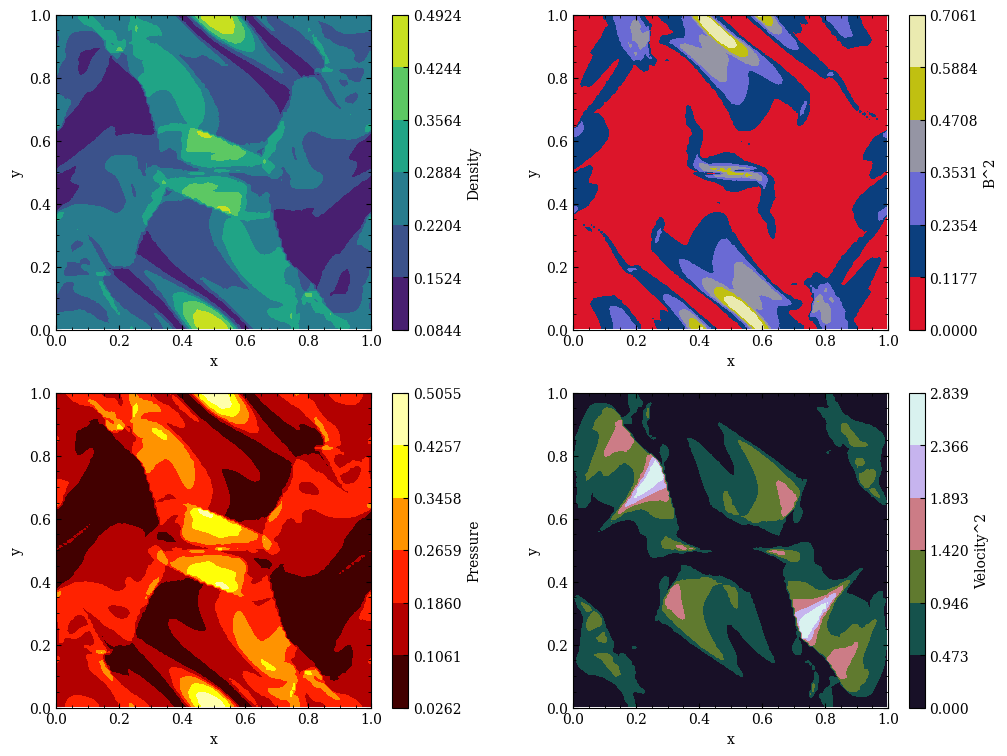

In [110]:
fig = plt.figure()
ratio = 0.75
sizex = 12.0
fig.set_size_inches(sizex,ratio*sizex)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Load RAMSES output
data = visu_ramses.load_snapshot(2)
x      = data["data"]["x"]
y      = data["data"]["y"]
dx     = data["data"]["dx"]
rho    = data["data"]["density"]
p      = data["data"]["pressure"]
b2     = 0.25*(data["data"]["B_x_left"]+data["data"]["B_x_right"])**2 + \
         0.25*(data["data"]["B_y_left"]+data["data"]["B_y_right"])**2 + \
         0.25*(data["data"]["B_z_left"]+data["data"]["B_z_right"])**2
u2     = data["data"]["velocity_x"]**2 + data["data"]["velocity_y"]**2

xmin = np.amin(x-0.5*dx)
xmax = np.amax(x+0.5*dx)
ymin = np.amin(y-0.5*dx)
ymax = np.amax(y+0.5*dx)

nx  = 128
dpx = (xmax-xmin)/float(nx)
dpy = (ymax-ymin)/float(nx)
xpx = np.linspace(xmin+0.5*dpx,xmax-0.5*dpx,nx)
ypx = np.linspace(ymin+0.5*dpy,ymax-0.5*dpy,nx)
grid_x, grid_y = np.meshgrid(xpx,ypx)
points = np.transpose([x,y])
z1 = griddata(points,rho,(grid_x,grid_y),method='nearest')
z2 = griddata(points,b2 ,(grid_x,grid_y),method='nearest')
z3 = griddata(points,p  ,(grid_x,grid_y),method='nearest')
z4 = griddata(points,u2 ,(grid_x,grid_y),method='nearest')

nc=7
im1 = ax1.contourf(xpx,ypx,z1,levels=np.linspace(np.amin(rho),np.amax(rho),nc))
im2 = ax2.contourf(xpx,ypx,z2,levels=np.linspace(np.amin(b2),np.amax(b2),nc),cmap='gist_stern')
im3 = ax3.contourf(xpx,ypx,z3,levels=np.linspace(np.amin(p),np.amax(p),nc),cmap='hot')
im4 = ax4.contourf(xpx,ypx,z4,levels=np.linspace(np.amin(u2),np.amax(u2),nc),cmap='cubehelix')

cb1 = plt.colorbar(im1,ax=ax1,label='Density')
cb2 = plt.colorbar(im2,ax=ax2,label='B^2')
cb3 = plt.colorbar(im3,ax=ax3,label='Pressure')
cb4 = plt.colorbar(im4,ax=ax4,label='Velocity^2')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([ymin,ymax])

fig.subplots_adjust(wspace=0.25)
fig.savefig('orszag-tang.pdf',bbox_inches='tight')

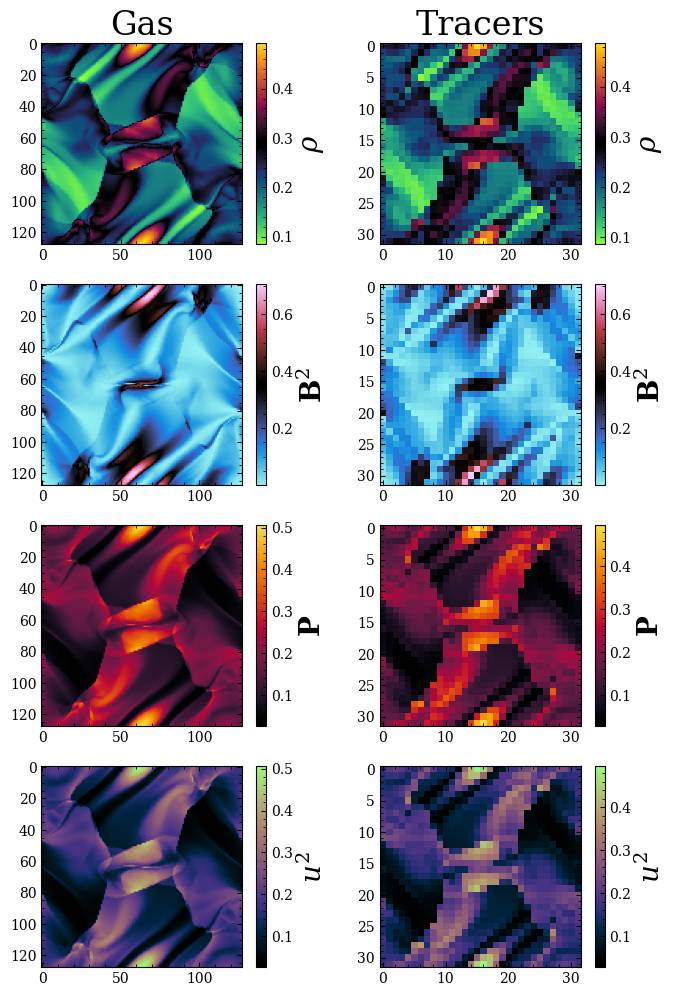

In [112]:
fig = plt.figure(figsize=(8, 12))

# density
plt.subplot(4,2,1)
plt.imshow(z1, cmap='cmr.wildfire')
cb1 = plt.colorbar()
cb1.set_label(label=r"$\rho$",fontsize=20)
plt.title("Gas",fontsize=24)

plt.subplot(4,2,2)
plt.imshow(z1_tracer, cmap='cmr.wildfire')
cb2 = plt.colorbar()
cb2.set_label(label=r"$\rho$",fontsize=20)
plt.title("Tracers",fontsize=24)

# mag
plt.subplot(4,2,3)
plt.imshow(z2, cmap='cmr.redshift')
cb1 = plt.colorbar()
cb1.set_label(label=r"$\mathbf{B}^2$",fontsize=20)

plt.subplot(4,2,4)
plt.imshow(z2_tracer, cmap='cmr.redshift')
cb2 = plt.colorbar()
cb2.set_label(label=r"$\mathbf{B}^2$",fontsize=20)

# pressure
plt.subplot(4,2,5)
plt.imshow(z3, cmap='cmr.ember')
cb1 = plt.colorbar()
cb1.set_label(label=r"$\mathbf{P}$",fontsize=20)

plt.subplot(4,2,6)
plt.imshow(z3_tracer, cmap='cmr.ember')
cb2 = plt.colorbar()
cb2.set_label(label=r"$\mathbf{P}$",fontsize=20)

# velocity
plt.subplot(4,2,7)
plt.imshow(z3, cmap='cmr.lilac')
cb1 = plt.colorbar()
cb1.set_label(label=r"$u^2$",fontsize=20)

plt.subplot(4,2,8)
plt.imshow(z3_tracer, cmap='cmr.lilac')
cb2 = plt.colorbar()
cb2.set_label(label=r"$u^2$",fontsize=20)

fig.savefig('orszag-tang-tracer.pdf',bbox_inches='tight')
fig.savefig('orszag-tang-tracer.png',bbox_inches='tight')